In [33]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

#for model saving:
import os
import tempfile
from pathlib import Path

In [86]:
# 1. Define a CEBRA model
cebra_model = CEBRA(
    model_architecture="offset10-model", #consider: "offset10-model-mse" if Euclidean
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    max_iterations=5000, #we will sweep later; start with default
    conditional='time', #for supervised, put 'time_delta', or 'delta'
    output_dimension=100,
    distance='cosine', #consider 'euclidean'; if you set this, output_dimension min=2
    device="cuda_if_available",
    verbose=True,
    time_offsets=10
)

In [96]:
#2. example data
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

In [94]:
hippocampus_pos?

Type:            _ParametrizedClass
String form:     RatDataset(name: achilles, shape: torch.Size([10178, 120]))
Length:          10178
File:            ~/anaconda3/envs/interpretable-neural-embeddings-env/lib/python3.10/site-packages/cebra/registry.py
Docstring:       <no docstring>
Class docstring:
A single rat hippocampus tetrode recording while the rat navigates on a linear track.

Neural data is spike counts binned into 25ms time window and the continuous behavior label is position and the running direction (left, right) of a rat.
The behavior label is structured as 3D array consists of position, right, and left.

Args:
    name: The name of the rat to use. Choose among 'achilles', 'buddy', 'cicero' and 'gatsby'.

In [103]:
cebra.datasets.hippocampus.get_options()

AttributeError: module 'cebra.datasets.hippocampus' has no attribute 'get_options'

In [101]:
cebra.datasets.hippocampus.SingleRatDataset(name='cicero', root='data', download=True).neural

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22.0M/22.0M [00:09<00:00, 2.36MB/s]

Download complete. Dataset saved in 'data/rat_hippocampus/cicero.jl'


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

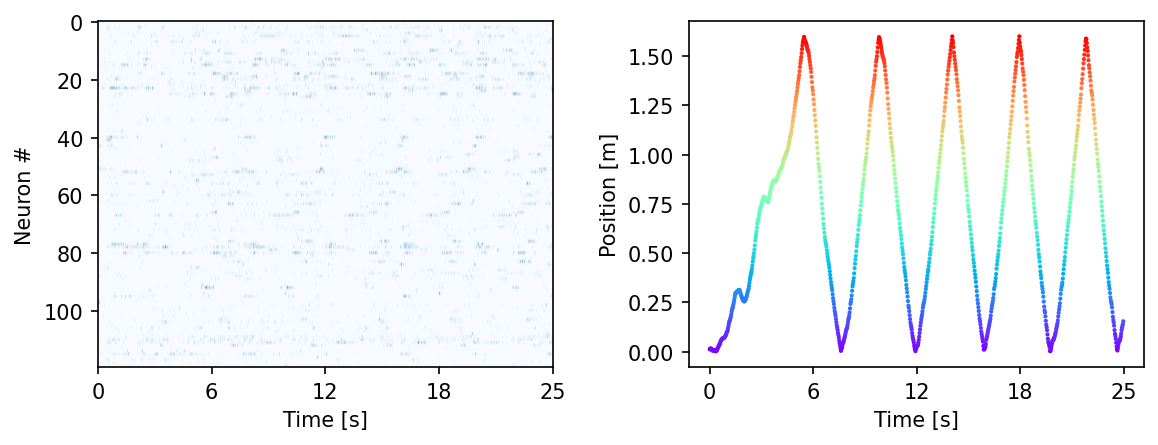

In [88]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'Blues')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos.continuous_index[:1000, 0],
            c=hippocampus_pos.continuous_index[:1000, 0], cmap='rainbow', s=1)

plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

pos: -0.8297 neg:  6.3357 total:  5.5059 temperature:  1.1200: 100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:34<00:00, 53.05it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 168.37it/s]

 GoF in bits - full: 1.0633121081276207


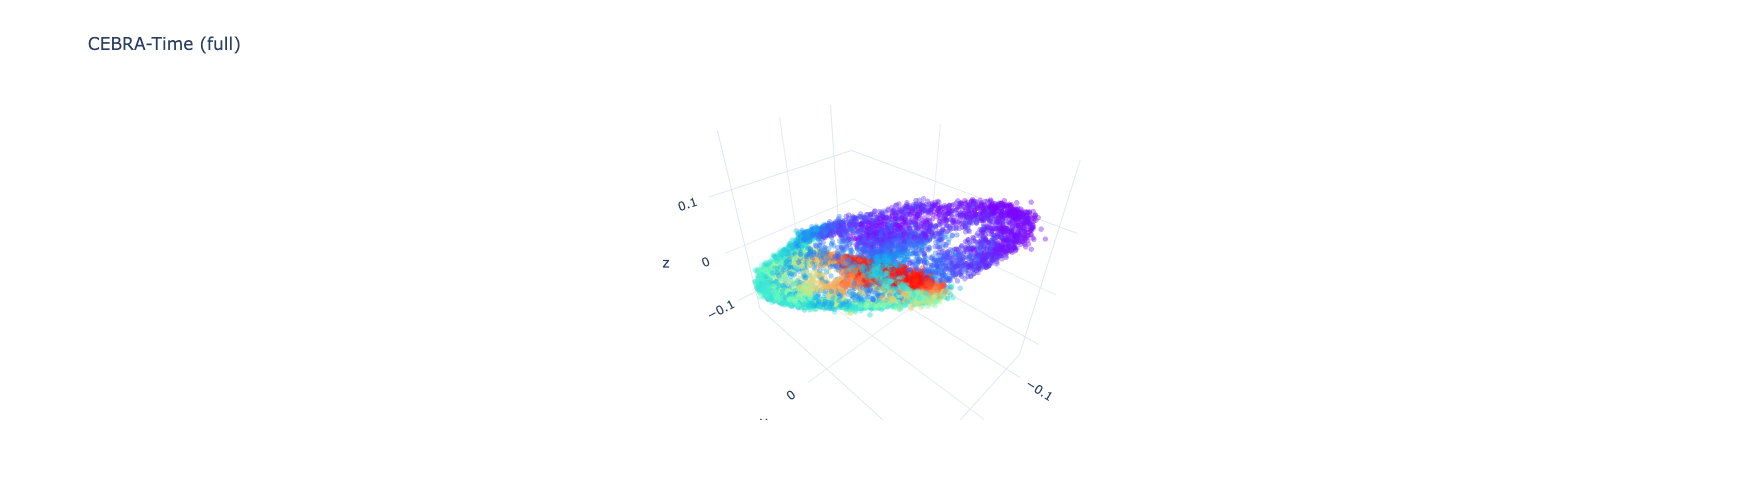

<Figure size 500x500 with 0 Axes>

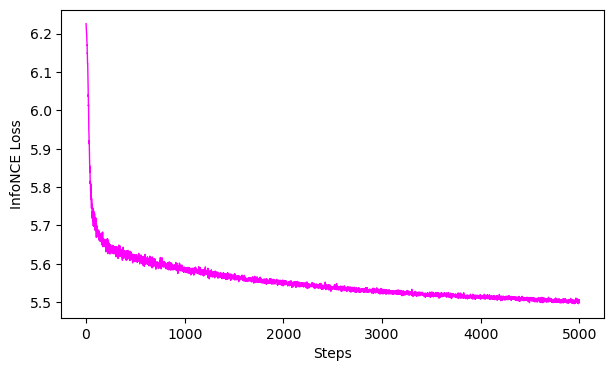

In [89]:
# fit
cebra_time_full_model = cebra_model.fit(hippocampus_pos.neural)
# transform
cebra_time_full = cebra_model.transform(hippocampus_pos.neural)
# GoF
gof_full = cebra.sklearn.metrics.goodness_of_fit_score(cebra_time_full_model, hippocampus_pos.neural)
print(" GoF in bits - full:", gof_full)
# plot embedding
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_time_full, embedding_labels=hippocampus_pos.continuous_index[:,0], title = "CEBRA-Time (full)", markersize=3, cmap = "rainbow")
fig.show()
# plot the loss curve
ax = cebra.plot_loss(cebra_time_full_model)

In [84]:
# 3. Split data and labels (labels we use later!)
from sklearn.model_selection import train_test_split
split_idx = int(0.8 * len(hippocampus_pos.neural)) #suggest: 5%-20% depending on your dataset size

train_data = hippocampus_pos.neural[:split_idx]
valid_data = hippocampus_pos.neural[split_idx:]

train_continuous_label = hippocampus_pos.continuous_index.numpy()[:split_idx]
valid_continuous_label = hippocampus_pos.continuous_index.numpy()[split_idx:]

In [85]:
cebra_train_model = cebra_model.fit(train_data)#, train_continuous_label)

pos: -0.7983 neg:  6.3918 total:  5.5935 temperature:  1.1200:  18%|██████████████▏                                                              | 921/5000 [00:14<01:03, 64.17it/s]


KeyboardInterrupt: 

In [42]:
tmp_file = Path(tempfile.gettempdir(), 'cebra.pt')
cebra_train_model.save(tmp_file)
#reload
cebra_train_model = cebra.CEBRA.load(tmp_file)

In [43]:
train_embedding = cebra_train_model.transform(train_data)
valid_embedding = cebra_train_model.transform(valid_data)

In [91]:
emb = cebra_model.transform(hippocampus_pos.neural)
emb

array([[ 0.01280984,  0.16093586,  0.15883633, ...,  0.06832846,
        -0.00959543, -0.00871227],
       [-0.00639958,  0.18133125,  0.16624452, ...,  0.05225709,
        -0.0187706 ,  0.00831662],
       [-0.03318524,  0.19684836,  0.15689372, ...,  0.04265537,
        -0.03434731,  0.03462418],
       ...,
       [ 0.02446389,  0.11823377,  0.12943347, ...,  0.09942585,
         0.00349961, -0.02165173],
       [ 0.03170335,  0.10446636,  0.11892051, ...,  0.09621597,
         0.007973  , -0.02014938],
       [ 0.03846667,  0.09530621,  0.11161523, ...,  0.09297515,
         0.01464791, -0.01948159]], shape=(10178, 100), dtype=float32)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 205.19it/s]


 GoF bits - train: 1.0346388688931971


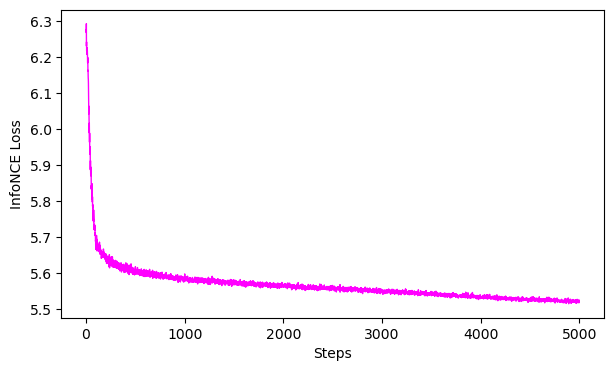

In [45]:
gof_train = cebra.sklearn.metrics.goodness_of_fit_score(cebra_train_model, train_data)
print(" GoF bits - train:", gof_train)

# plot the loss curve
ax = cebra.plot_loss(cebra_train_model)

<Axes3D: title={'center': 'Embedding'}>

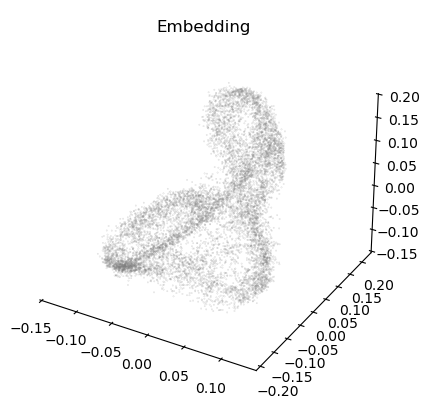

In [92]:
cebra.plot_embedding(emb)

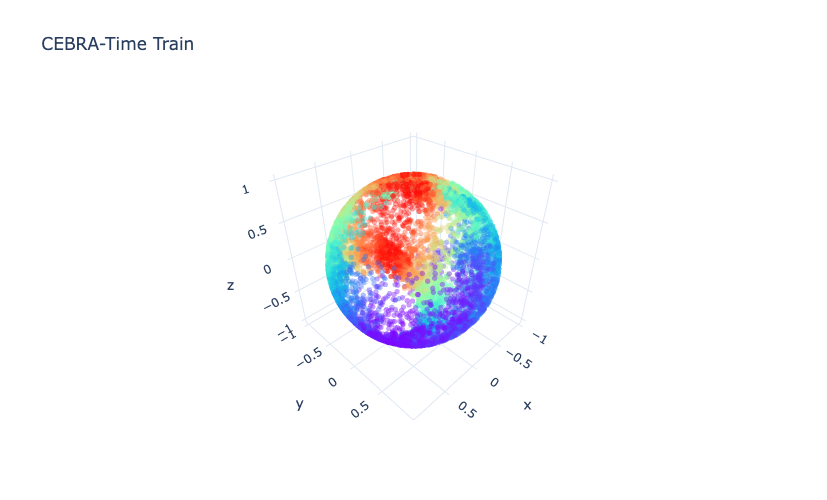

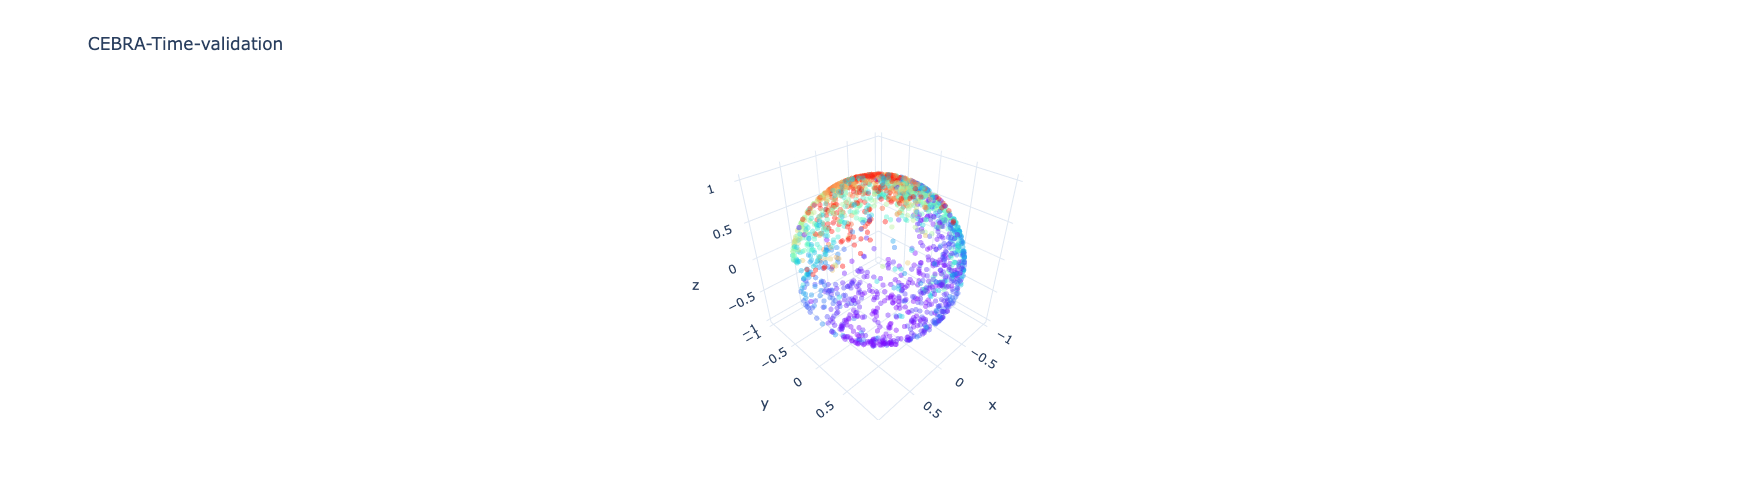

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [46]:
import cebra.integrations.plotly
#train
fig = cebra.integrations.plotly.plot_embedding_interactive(train_embedding,
                                                           embedding_labels=train_continuous_label[:,0],
                                                           title = "CEBRA-Time Train",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

#validation
fig = cebra.integrations.plotly.plot_embedding_interactive(valid_embedding,
                                                           embedding_labels=valid_continuous_label[:,0],
                                                           title = "CEBRA-Time-validation",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

In [47]:
### Now we are going to run our train/val. 5-10 times to be sure they are consistent!

X = 5  # Number of training runs
model_paths = []  # Store file paths

for i in range(X):
    print(f"Training 🦓CEBRA model {i+1}/{X}")

    # Train and save model
    cebra_train_model = cebra_model.fit(train_data)
    tmp_file = Path(tempfile.gettempdir(), f'cebra_{i}.pt')
    cebra_train_model.save(tmp_file)
    model_paths.append(tmp_file)

### Reload models and transform data
train_embeddings = []
valid_embeddings = []

for tmp_file in model_paths:
    cebra_train_model = cebra.CEBRA.load(tmp_file)
    train_embeddings.append(cebra_train_model.transform(train_data))
    valid_embeddings.append(cebra_train_model.transform(valid_data))

Training 🦓CEBRA model 1/5


pos: -0.8505 neg:  6.3679 total:  5.5174 temperature:  1.1200: 100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:06<00:00, 75.68it/s]


Training 🦓CEBRA model 2/5


pos: -0.8550 neg:  6.3694 total:  5.5144 temperature:  1.1200: 100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:06<00:00, 74.95it/s]


Training 🦓CEBRA model 3/5


pos: -0.8403 neg:  6.3718 total:  5.5315 temperature:  1.1200: 100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:40<00:00, 17.79it/s]


Training 🦓CEBRA model 4/5


pos: -0.8546 neg:  6.3702 total:  5.5156 temperature:  1.1200: 100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:07<00:00, 39.21it/s]


Training 🦓CEBRA model 5/5


pos: -0.8464 neg:  6.3702 total:  5.5238 temperature:  1.1200: 100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:06<00:00, 74.66it/s]


<Axes: >

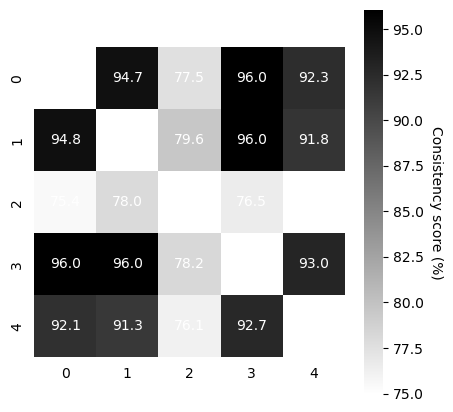

In [48]:
scores, pairs, ids_runs = cebra.sklearn.metrics.consistency_score(
    embeddings=train_embeddings,
    between="runs"
)

cebra.plot_consistency(scores, pairs, ids_runs)

<Axes: >

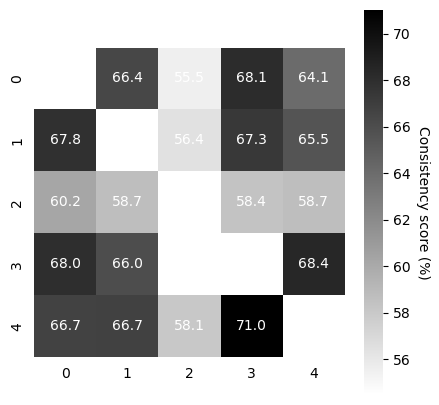

In [49]:
scores, pairs, ids_runs = cebra.sklearn.metrics.consistency_score(
    embeddings=valid_embeddings,
    between="runs"
)

cebra.plot_consistency(scores, pairs, ids_runs)

In [116]:
os.getcwd()

'/Users/arjun/.Trash/notebooks'

In [105]:
cebra.models.get_options()

['offset10-model',
 'offset10-model-mse',
 'offset5-model',
 'offset1-model-mse',
 'offset1-model',
 'offset1-model-v2',
 'offset1-model-v3',
 'offset1-model-v4',
 'offset1-model-v5',
 'offset40-model-4x-subsample',
 'resample-model',
 'offset20-model-4x-subsample',
 'resample5-model',
 'offset4-model-2x-subsample',
 'resample1-model',
 'supervised10-model',
 'supervised1-model',
 'offset36-model',
 'offset36-model-dropout',
 'offset36-model-more-dropout']

In [109]:
#%mkdir saved_models

params_grid = dict(
    output_dimension = [3],
    time_offsets = [5],
    model_architecture=['offset10-model'],
    temperature_mode='constant',
    temperature=[0],
    max_iterations=[10, 20],
    device='cuda_if_available',
    num_hidden_units = [5, 10],
    verbose = True)

datasets = {"dataset1": train_data}
# run the grid search
grid_search = cebra.grid_search.GridSearch()
grid_search.fit_models(datasets, params=params_grid, models_dir="saved_models")

pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.57it/s]
pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]
pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.52it/s]
pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.53it/s]


In [110]:
df_results = grid_search.get_df_results(models_dir="saved_models")

In [117]:
df_results

max_iterations  num_hidden_units  loss dataset_name
0              10                 5   NaN     dataset1
1              10                10   NaN     dataset1
2              20                 5   NaN     dataset1
3              20                10   NaN     dataset1

In [124]:
hippocampus_pos.continuous_index.shape


torch.Size([10178, 3])

In [112]:
# Get the results
df_results = grid_search.get_df_results(models_dir="saved_models")

# Get the best model for a given dataset
best_model, best_model_name = grid_search.get_best_model(dataset_name="dataset1", models_dir="saved_models")
print("The best model is:", best_model_name)

ValueError: Invalid dataset name, that dataset wasn't find in the list of fitted models, got dataset1.

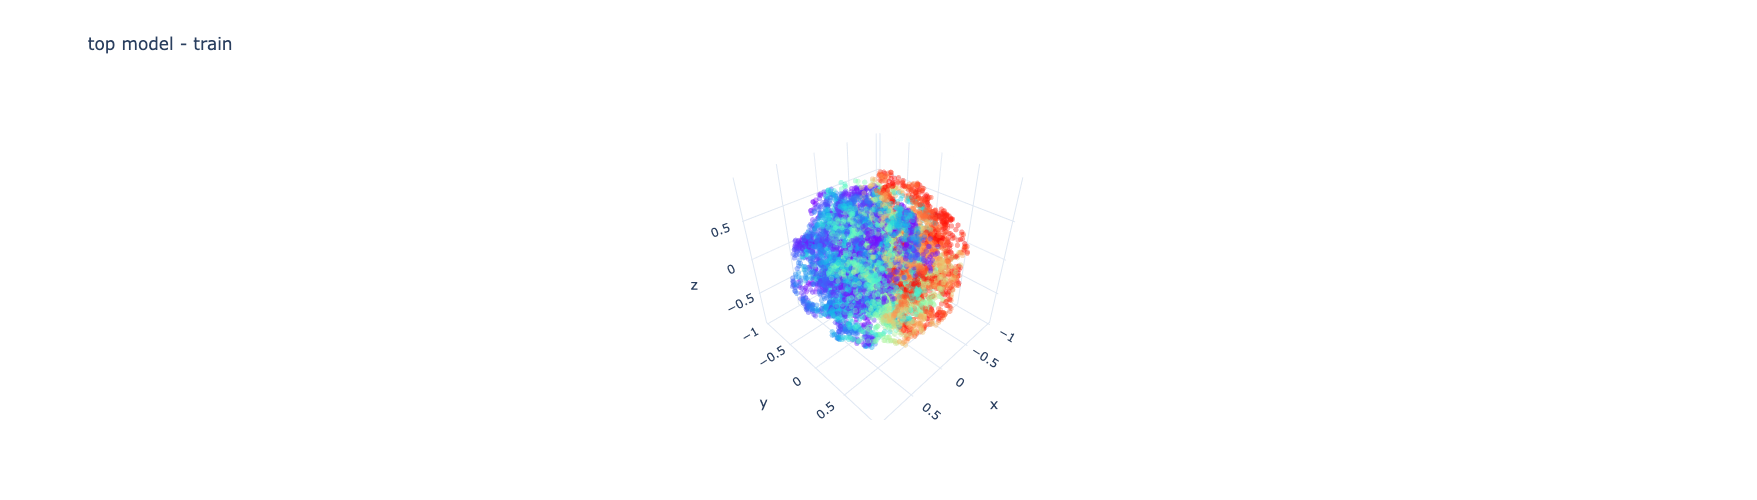

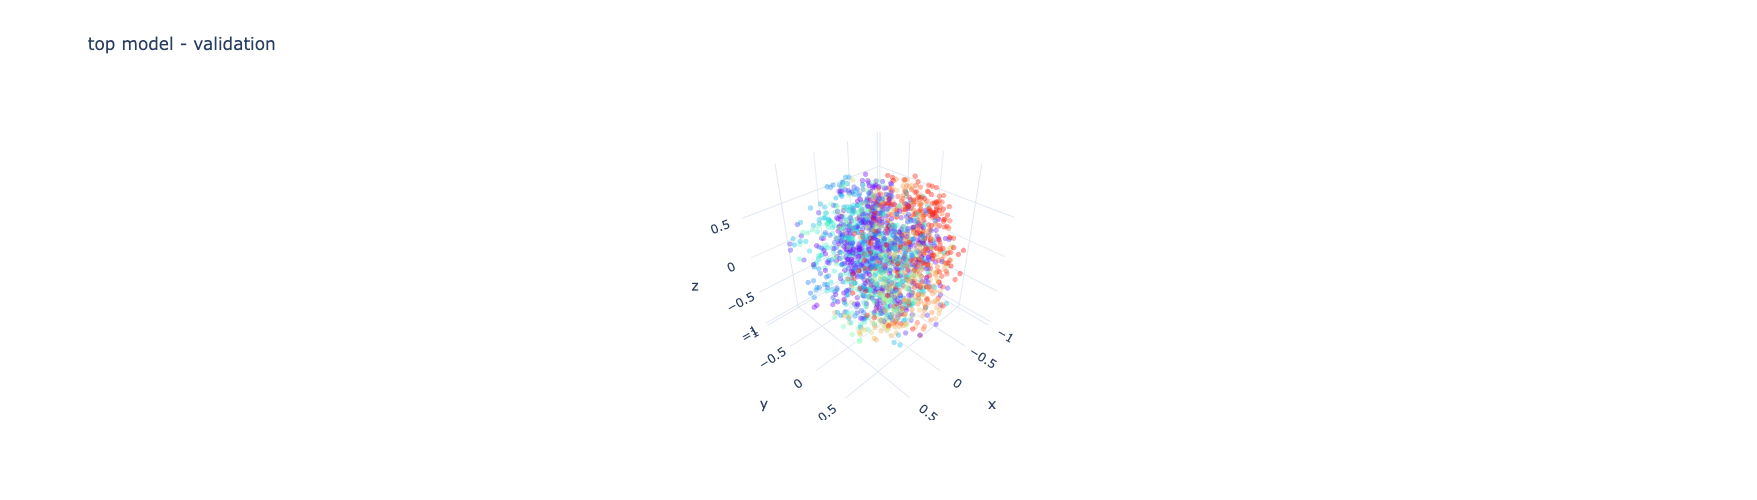

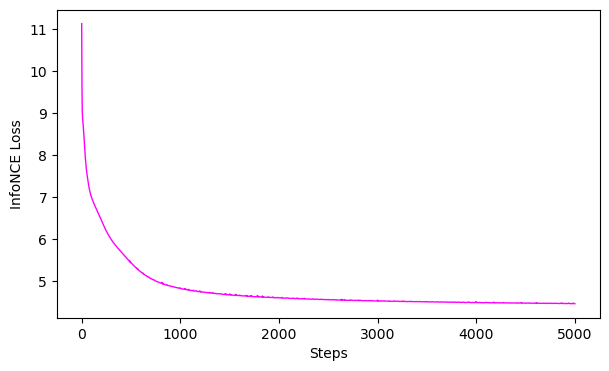

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [60]:
#load the top model ✨
model_path = Path("/Users/arjun/cse599/interpretable-neural-embeddings/notebooks/saved_models") / f"{best_model_name}.pt"
top_model = cebra.CEBRA.load(model_path)

#transform:
top_train_embedding = top_model.transform(train_data)
top_valid_embedding = top_model.transform(valid_data)

# plot the loss curve
ax = cebra.plot_loss(top_model)


# plot embeddings
fig = cebra.integrations.plotly.plot_embedding_interactive(top_train_embedding,
                                                           embedding_labels=train_continuous_label[:,0],
                                                           title = "top model - train",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

fig = cebra.integrations.plotly.plot_embedding_interactive(top_valid_embedding,
                                                           embedding_labels=valid_continuous_label[:,0],
                                                           title = "top model - validation",
                                                           markersize=3,
                                                           cmap = "rainbow")
fig.show()

In [90]:
train_embeddings

[array([[-0.27928835,  0.24560861, -0.9282642 ],
        [-0.18131644,  0.48014766, -0.8582439 ],
        [-0.12821107,  0.70260257, -0.69993687],
        ...,
        [-0.45348775,  0.67043024, -0.5872582 ],
        [-0.3470008 ,  0.7876834 , -0.5090631 ],
        [ 0.21642229,  0.9301316 ,  0.2966761 ]],
       shape=(8142, 3), dtype=float32),
 array([[ 0.01487515, -0.2803079 , -0.9597949 ],
        [ 0.06735789, -0.2749094 , -0.95910776],
        [ 0.12826626, -0.16012596, -0.97872746],
        ...,
        [ 0.49695033,  0.37528318, -0.7824339 ],
        [ 0.41281605,  0.2675227 , -0.87064034],
        [ 0.4376348 ,  0.73225814, -0.52179855]],
       shape=(8142, 3), dtype=float32),
 array([[ 0.64603955,  0.5524018 , -0.52676857],
        [ 0.7368379 ,  0.5868183 , -0.3357295 ],
        [ 0.7405919 ,  0.6255466 , -0.24538755],
        ...,
        [ 0.5354068 ,  0.8121315 , -0.23190919],
        [ 0.7435001 ,  0.6590947 , -0.1131451 ],
        [ 0.92940235,  0.3466975 ,  0.12653878

In [63]:
train_embeddings

[array([[-0.27928835,  0.24560861, -0.9282642 ],
        [-0.18131644,  0.48014766, -0.8582439 ],
        [-0.12821107,  0.70260257, -0.69993687],
        ...,
        [-0.45348775,  0.67043024, -0.5872582 ],
        [-0.3470008 ,  0.7876834 , -0.5090631 ],
        [ 0.21642229,  0.9301316 ,  0.2966761 ]],
       shape=(8142, 3), dtype=float32),
 array([[ 0.01487515, -0.2803079 , -0.9597949 ],
        [ 0.06735789, -0.2749094 , -0.95910776],
        [ 0.12826626, -0.16012596, -0.97872746],
        ...,
        [ 0.49695033,  0.37528318, -0.7824339 ],
        [ 0.41281605,  0.2675227 , -0.87064034],
        [ 0.4376348 ,  0.73225814, -0.52179855]],
       shape=(8142, 3), dtype=float32),
 array([[ 0.64603955,  0.5524018 , -0.52676857],
        [ 0.7368379 ,  0.5868183 , -0.3357295 ],
        [ 0.7405919 ,  0.6255466 , -0.24538755],
        ...,
        [ 0.5354068 ,  0.8121315 , -0.23190919],
        [ 0.7435001 ,  0.6590947 , -0.1131451 ],
        [ 0.92940235,  0.3466975 ,  0.12653878

In [72]:
len(train_embeddings)

5

In [75]:
train_embeddings[0].shape + valid_embeddings[0].shape

(8142, 3, 2036, 3)

In [69]:
hippocampus_pos.continuous_index.shape

torch.Size([10178, 3])

In [62]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Example: Predict position (continuous)
reg = Ridge(alpha=1.0)
reg.fit(train_embeddings, hippocampus_pos.continuous_index)   # train_labels = position or direction
pred = reg.predict(valid_embeddings)

# Evaluate R²
r2 = r2_score(valid_labels, pred)
print(f"Baseline R² from dense embeddings: {r2:.3f}")


ValueError: Found array with dim 3. Ridge expected <= 2.